In [170]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import lightgbm as lgbm

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt

import seaborn as sns

In [171]:
def plot_column(X, y, X_label, y_label, plot_size=(15, 6), save=False, alpha=0.8):
    ''' 
    Plots a column from the turbine dataset using the fivethirtyeight style.
    '''
    # Use tivethirtyeight as a sytle because it looks really nice

    plt.clf()
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=plot_size)

    ax = plt.subplot(111)

    # Plot the first 1000 datapoints of power generated
    ax.scatter(X, y, marker='.', alpha=alpha)

    # Set labels and rotate x labels for better readabilty
    ax.set_xlabel(X_label)
    ax.set_ylabel(y_label)
    
    if save:
        plt.savefig('column.png', dpi=50, bbox_inches = 'tight')

def plot_preds(y_test, y_hat,):
    plt.clf()
    plt.figure(figsize=(25, 5))

    plt.plot(range(len(y_test)), y_test, '-', color="green", label="actual")
    plt.plot(range(len(y_test)), y_hat, '-', color="orange", label="predicted")

    plt.legend()    
    plt.show()

In [172]:
df = pd.read_csv("bike_train_data.csv")

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [174]:
df["datetime"] = pd.to_datetime(df["datetime"])

In [175]:
min_date = df["datetime"].min()
max_date = df["datetime"].max()

print("Min date is: ", min_date)
print("Max date is: ", max_date)

Min date is:  2011-01-01 00:00:00
Max date is:  2012-12-19 23:00:00


In [176]:
df["hour_of_day"] = df["datetime"].dt.hour
df["day_of_week"] = df["datetime"].dt.day_of_week
df["day_of_year"] = df["datetime"].dt.day_of_year

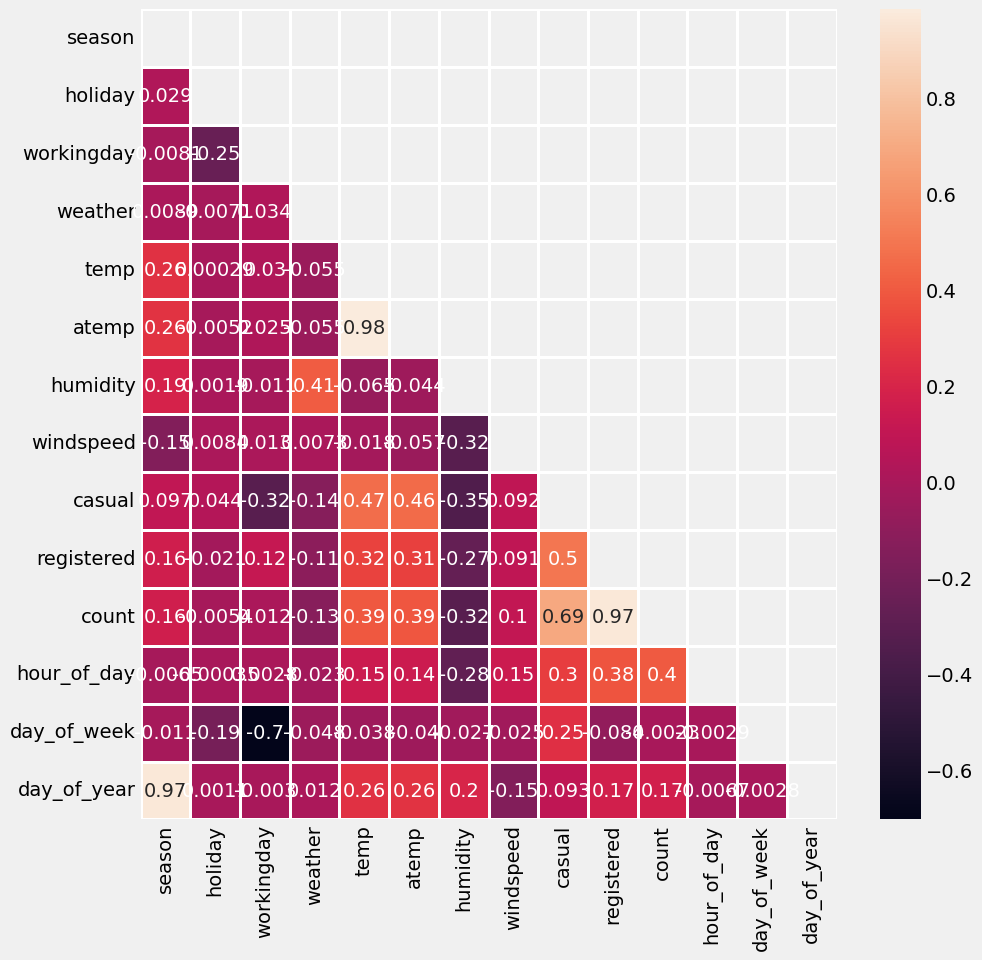

In [177]:
plt.figure(figsize=(10, 10))

corr = df.corr()

# Get only the lower half
matrix = np.triu(corr)

heat_map = sns.heatmap(corr, linewidth = 1, annot = True, mask=matrix)
plt.show()

<Figure size 640x480 with 0 Axes>

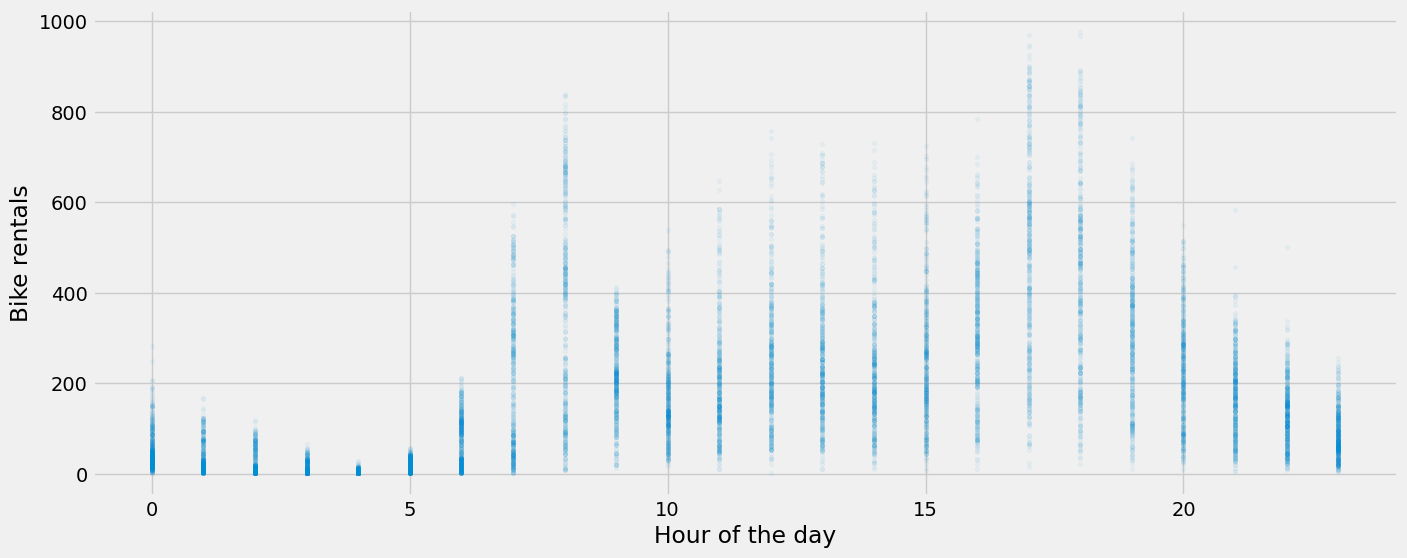

In [178]:
plot_column(df["hour_of_day"], df["count"], X_label="Hour of the day", y_label="Bike rentals", save=False, alpha=0.05)

<Figure size 640x480 with 0 Axes>

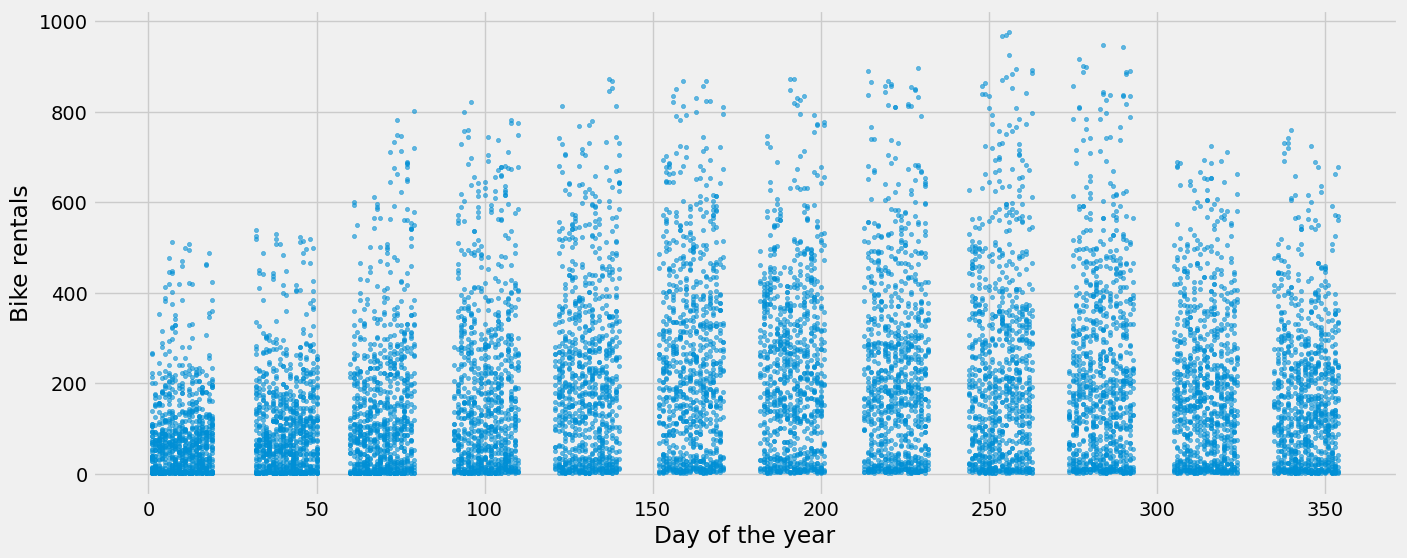

In [179]:
plot_column(df["day_of_year"], df["count"], X_label="Day of the year", y_label="Bike rentals", save=False, alpha=0.6)

<Figure size 640x480 with 0 Axes>

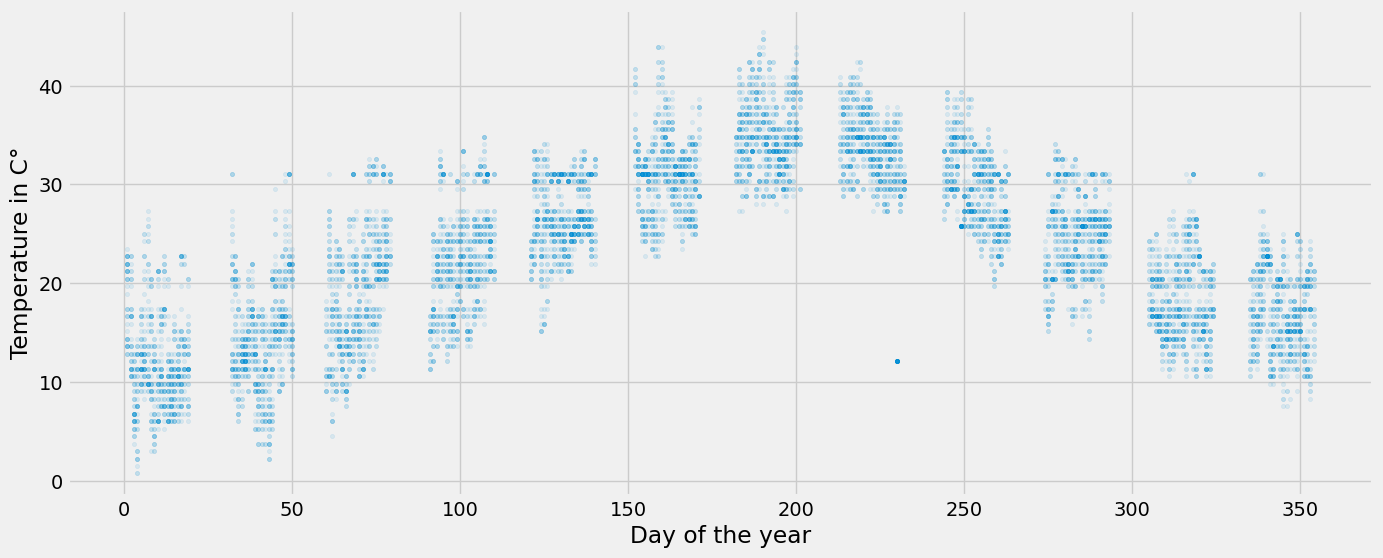

In [180]:
plot_column(df["day_of_year"], df["atemp"], X_label="Day of the year", y_label="Temperature in C°", save=False, alpha=0.1)

<Figure size 640x480 with 0 Axes>

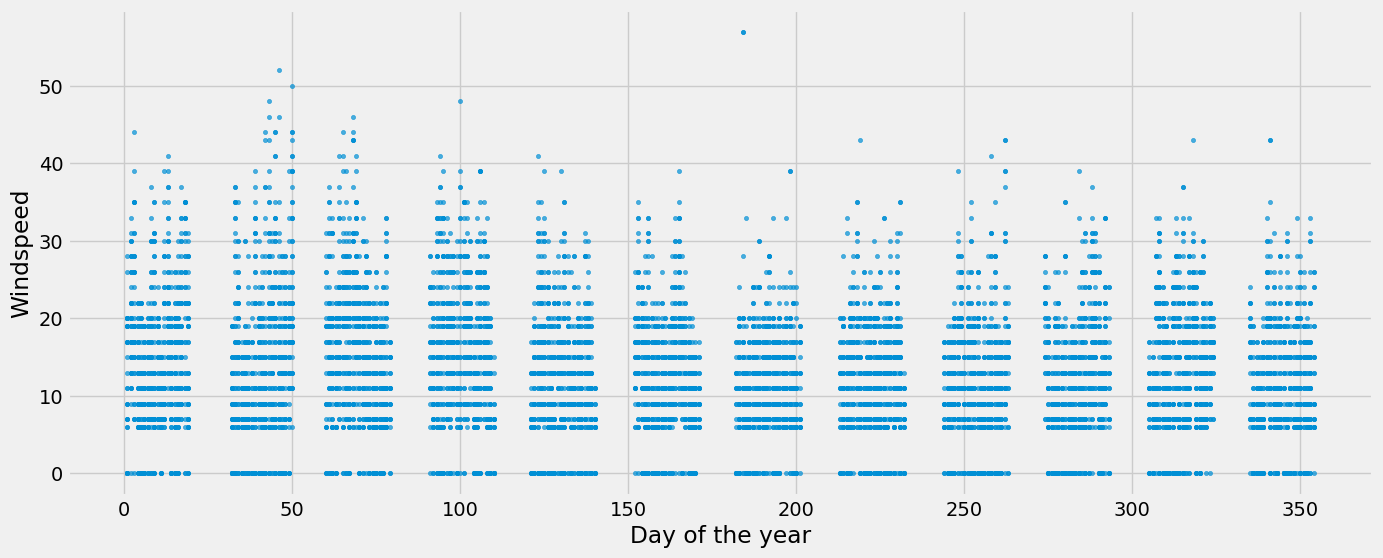

In [181]:
plot_column(df["day_of_year"], df["windspeed"], X_label="Day of the year", y_label="Windspeed", save=False, alpha=0.7)

In [182]:
# Shift count values into the future
df["count_shifted"] = df["count"].shift(-1).fillna(0).astype("int")

In [183]:
X = df.drop(["count", "casual", "registered", "count_shifted", "datetime"], axis=1)
y = df["count_shifted"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [184]:
print("Len X_train: ", len(X_train))
print("Len y_train: ", len(y_train))
print("Len X_test: ", len(X_test))
print("Len y_test: ", len(y_test))

Len X_train:  7620
Len y_train:  7620
Len X_test:  3266
Len y_test:  3266


In [ ]:
# Random search CV for a decision tree regressor
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
search_grid = {
    "max_depth": [int(x) for x in np.linspace(1, 100, num = 100)],
    "min_samples_leaf": [int(x) for x in np.linspace(1, 10, num = 10)],
    "min_samples_split": [int(x) for x in np.linspace(1, 10, num = 10)],
    "ccp_alpha": [float(x) for x in np.linspace(0, 1, num = 100)],
}

dtr = DecisionTreeRegressor()
dtr_random = RandomizedSearchCV(
    estimator=dtr, 
    param_distributions=search_grid, 
    scoring="neg_mean_squared_error",
    n_iter=25, 
    cv=3, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1).fit(X_train, y_train)

In [186]:
print("Best parameters: ", dtr_random.best_params_)
print("Best score: ", dtr_random.best_score_)

Best parameters:  {'min_samples_split': 10, 'min_samples_leaf': 8, 'max_depth': 19, 'ccp_alpha': 0.32323232323232326}
Best score:  -6939.847199724478


In [187]:
dtr = DecisionTreeRegressor(**dtr_random.best_params_).fit(X_train, y_train)
y_hat = dtr.predict(X_test)

In [188]:
print("Mean absolute error: ", round(mean_absolute_error(y_test, y_hat),2))
print("Root mean squared error: ", round(mean_squared_error(y_test, y_hat, squared=False), 2))

Mean absolute error:  52.95
Root mean squared error:  81.27


<Figure size 640x480 with 0 Axes>

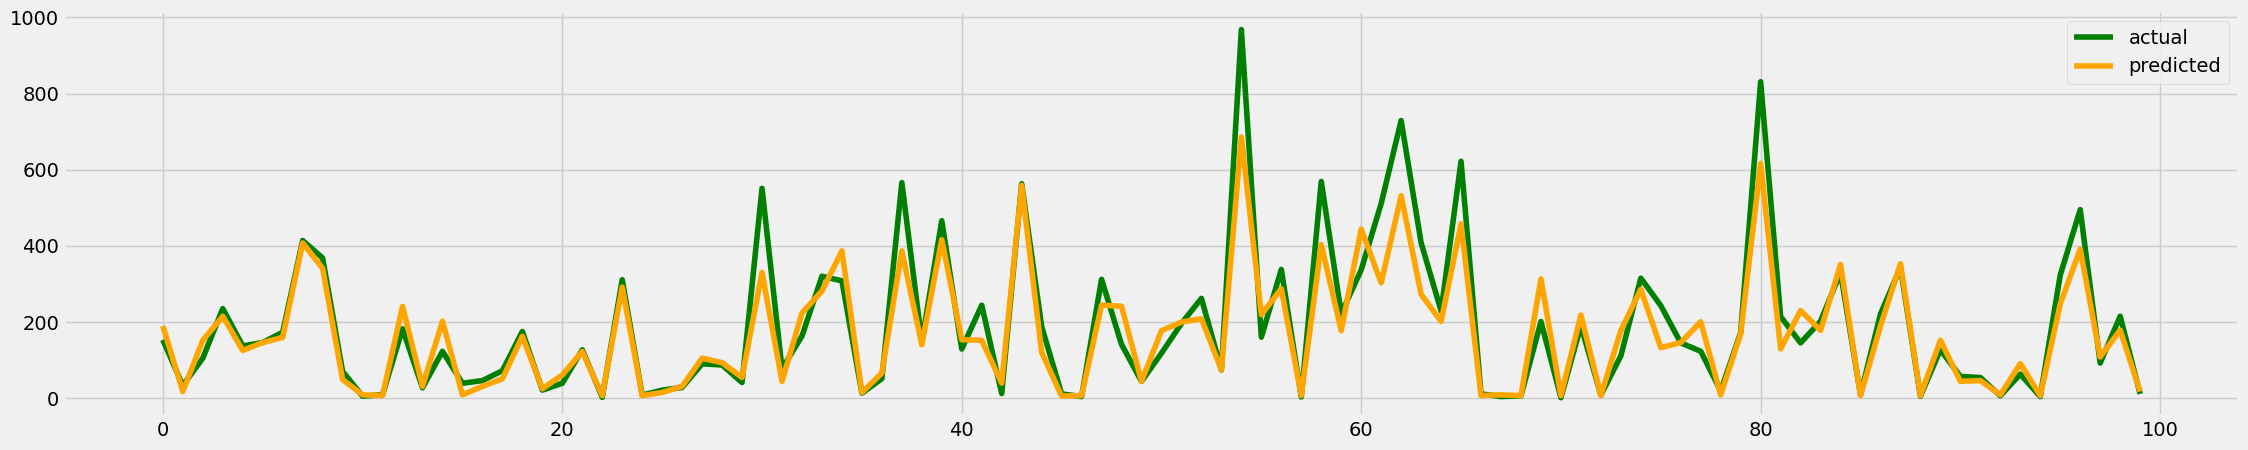

In [189]:
plot_preds(y_test[:100], y_hat[:100])

## Repeat with LGBM

In [ ]:

# Number of trees in random forest
lgbm_search_grid = {
    "n_estimators": [int(x) for x in np.linspace(1, 100, num = 100)],
    "max_depth": [int(x) for x in np.linspace(1, 100, num = 100)],
    "min_child_samples": [int(x) for x in np.linspace(1, 10, num = 10)],
    "reg_alpha": [float(x) for x in np.linspace(0, 1, num = 100)],
    "reg_alpha": [float(x) for x in np.linspace(0, 1, num = 100)],
    "learning_rate": [float(x) for x in np.linspace(0, 1, num = 100)],
}

lgbr = lgbm.LGBMRegressor()
lgbm_random = RandomizedSearchCV(
    estimator=lgbr, 
    param_distributions=lgbm_search_grid, 
    scoring="neg_mean_squared_error",
    n_iter=100, 
    cv=3, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1).fit(X_train, y_train)

In [195]:
print("Best parameters: ", lgbm_random.best_params_)
print("Best score: ", lgbm_random.best_score_)

Best parameters:  {'reg_alpha': 0.5151515151515152, 'n_estimators': 87, 'min_child_samples': 7, 'max_depth': 30, 'learning_rate': 0.23232323232323235}
Best score:  -3763.655544360158


In [197]:
lgbr = lgbm.LGBMRegressor(**lgbm_random.best_params_).fit(X_train, y_train)
lgbm_y_hat = lgbr.predict(X_test)

In [198]:
print("Mean absolute error: ", round(mean_absolute_error(y_test, lgbm_y_hat),2))
print("Root mean squared error: ", round(mean_squared_error(y_test, lgbm_y_hat, squared=False), 2))

Mean absolute error:  40.47
Root mean squared error:  59.82


<Figure size 640x480 with 0 Axes>

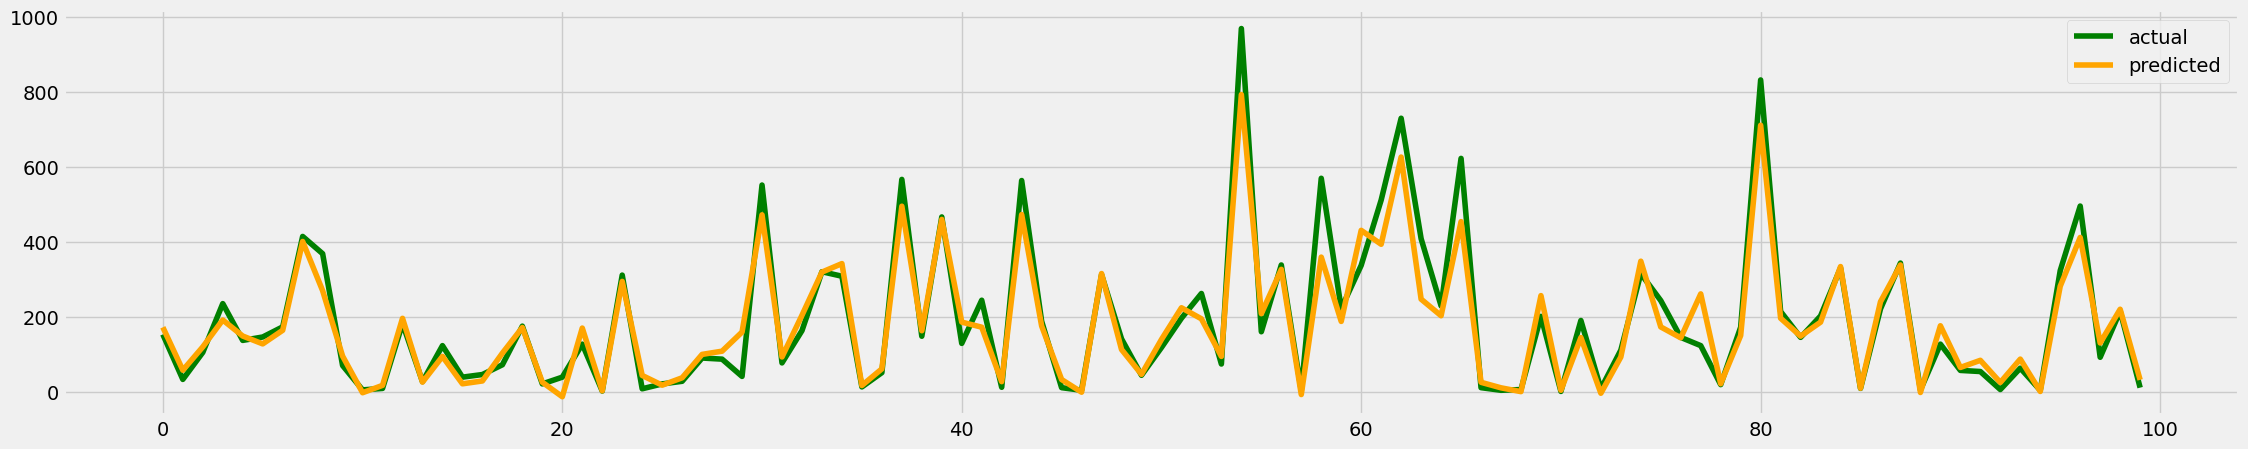

In [199]:
# It is noticable that the LGBMRegressor performs better than the DecisionTreeRegressor, especially at peak hours.
plot_preds(y_test[:100], lgbm_y_hat[:100])

## Feature importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

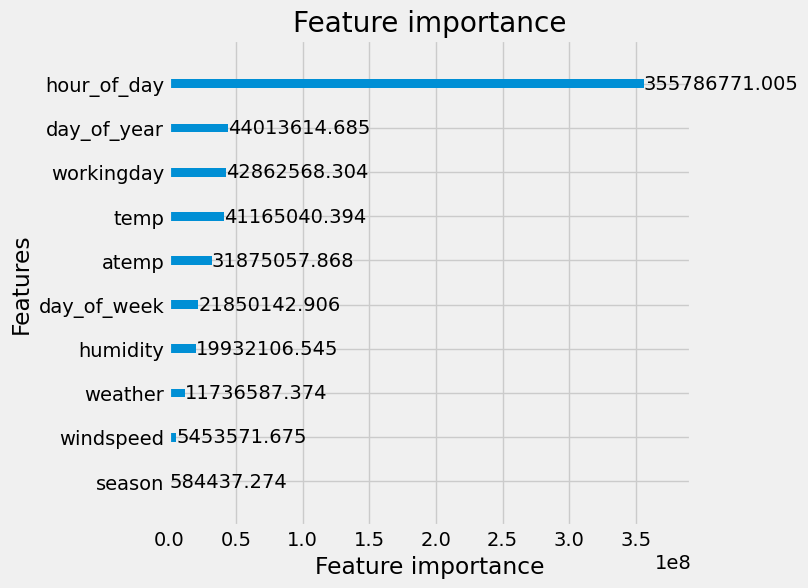

In [202]:
lgbm.plot_importance(lgbr, figsize=(6, 6), importance_type="gain", max_num_features=10)